In [8]:
import pandas as pd
import numpy as np
import networkx as nx
import pyodbc
import sqlite3
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec
from datetime import datetime
#import sql_queries
#import server_details
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('ggplot')

## Setup  
If you've moved this file or the sqlite dummy database out of their default locations, update the filepath.

In [12]:
sqlite_location = '..//member_net//demo_data.db'
MSSQL_server_name = 'xxxx'
datamart_name = 'xxxx'

In [14]:
#########################################################
# SQLITE QUERIES
########################################################

sqlite_node_individual_query = '''
SELECT individual_id,
first_name ||' '||last_name||' '||individual_id [label],
first_name ||' '||last_name [name],
open_date,
'individual'[type]
from individual_today
'''

sqlite_member_individual_query = '''
SELECT *, member_nbr [label],
'membership'[type]
FROM agr_membertotal_today
'''

sqlite_edge_query = '''
select member_nbr [source], individual_id [target], participation_type
FROM membershipparticipant_today
'''

########################################################
# MS SQL (Data Explorer) QUERIES
# Need to add filter for real accounts!
#######################################################

ms_sql_node_individual_query = '''
SELECT individual_id,
first_name + space(1) + last_name + space(1) + str(individual_id) [label],
first_name + space(1) + last_name [name],
-- open date equivalent
'individual' type
FROM individual_today

'''

ms_sql_member_individual_query = '''
SELECT *, member_nbr [label], 'membership' [type]
FROM AGR_MEMBERTOTAL_TODAY

'''

ms_sql_edge_query = '''
SELECT member_nbr [source], individual_id [target], participation_type
FROM membershipparticipant_today
'''

## Create graph

In [15]:
def generate_member_graph(db_type):
    '''Generates the graph object using either sqlite or the datamart db.
    :param db_type: sqlite or datamart
    :return G: graph object
    :return ind: dataframe of the individuals, required to generate the color map.
    '''
    
    #sqlite_location = 'demo_data.db'
    #MSSQL_server_name = 'xxxx'
    #datamart_name = 'xxxx'
    
    if db_type == 'sqlite':
        conn = sqlite3.connect(sqlite_location)
        ind = pd.read_sql(sqlite_node_individual_query, conn)
        mem = pd.read_sql(sqlite_member_individual_query, conn)
        edges= pd.read_sql(sqlite_edge_query, conn)
    
    elif db_type == 'datamart':
        conn = pyodbc.connect('Driver={SQL Server};'
                      'Server='+str(MSSQL_server_name)+';'
                      'Database='+str(datamart_name)+';'
                      'Trusted_Connection=yes;')
        
        ind = pd.read_sql(ms_sql_node_individual_query, conn)
        mem = pd.read_sql(ms_sql_member_individual_query, conn)
        edges= pd.read_sql(ms_sql_edge_query, conn)
    
    else:
        raise ValueError("Please specify 'sqlite' or 'datamart'")

    # make attribute dictionary
    mem_dict = mem.set_index('MEMBER_NBR')
    mem_dict = mem_dict.to_dict('index')
    ind_dict = ind.set_index('INDIVIDUAL_ID')
    ind_dict = ind_dict.to_dict('index')

    mem_dict.update(ind_dict)

    # from pandas edgelist
    G = nx.from_pandas_edgelist(edges, edge_attr = True)
    nx.set_node_attributes(G, mem_dict) 
    
    return G, ind

In [16]:
G, ind = generate_member_graph('sqlite')

In [17]:
ind

,INDIVIDUAL_ID,label,name,OPEN_DATE,type
0,4611,Cayden Hebert 4611,Cayden Hebert,2017-05-19,individual
1,6661,Vincent Frazier 6661,Vincent Frazier,2018-06-02,individual
2,1547,Aaron Ortega 1547,Aaron Ortega,2005-05-16,individual
3,7700,Kennedy Williamson 7700,Kennedy Williamson,2012-07-29,individual
4,6179,Julian Gonzalez 6179,Julian Gonzalez,2019-12-06,individual
...,...,...,...,...,...
95,4587,Brantley Woodward 4587,Brantley Woodward,2010-07-19,individual
96,5104,Adam Doyle 5104,Adam Doyle,2004-04-26,individual
97,9204,Elizabeth Mendoza 9204,Elizabeth Mendoza,2014-04-29,individual
98,9210,Sawyer Cuevas 9210,Sawyer Cuevas,2014-10-17,individual


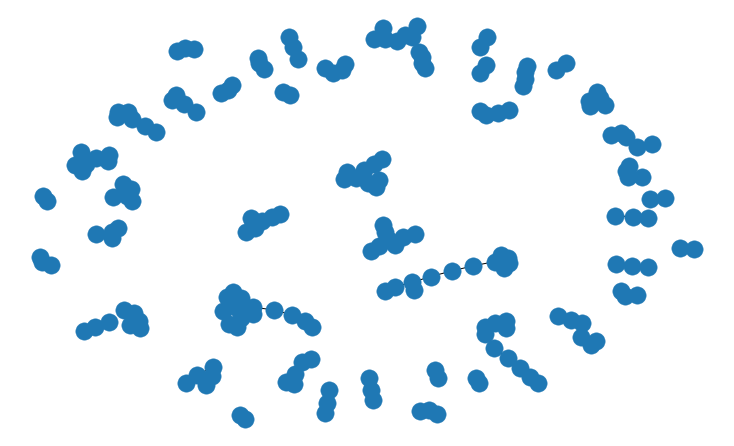

In [18]:
nx.draw(G)

### Graph stats

In [19]:
print(nx.info(G))
print(f'Connected components: {str(nx.number_connected_components(G))}')

Name: 
Type: Graph
Number of nodes: 199
Number of edges: 150
Average degree:   1.5075
Connected components: 49


In [20]:
# Degrees
degree = nx.degree(G)
#degree

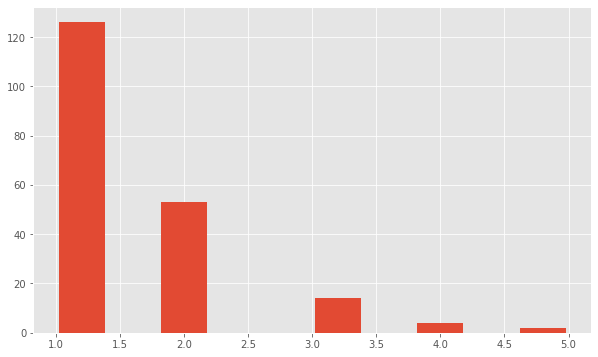

In [21]:
#Degree histogram
plt.rcParams['figure.figsize'] = (10, 6)
degrees = [node[1] for node in degree]
#print (degrees)
plt.hist(degrees, rwidth=0.9)
plt.show()

#plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth))

In [22]:
degrees_filtered = [node for node in degrees if node>2]
degrees_filtered

[5, 4, 3, 4, 3, 4, 3, 3, 4, 3, 3, 3, 3, 5, 3, 3, 3, 3, 3, 3]

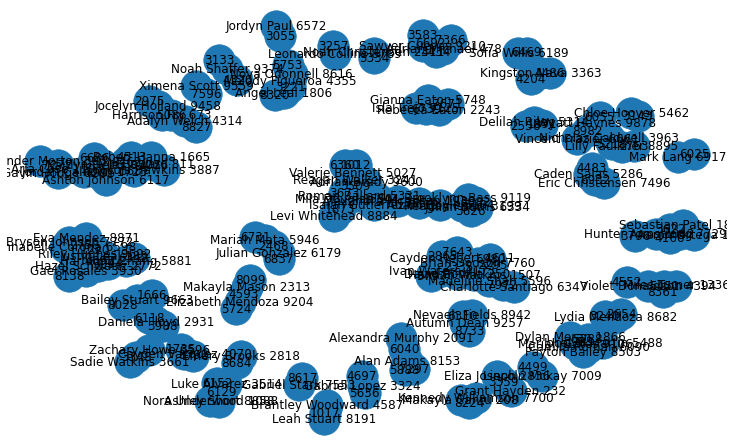

In [23]:
# Show all participants
pos = nx.spring_layout(G)
node_labels = nx.get_node_attributes(G,'label')
nx.draw(G, pos=pos,   node_size=1000)
nx.draw_networkx_labels(G, pos=pos, labels=node_labels )
plt.show()

### Data prep and examining subgraphs

In [24]:
# Saved in member_subnetwork_functions.py
def generate_color_map(graph_object, individual_df):
    ''' Generates a color map corresponding with whether a node represents an individual or membership
    :param graph_object: NetworkX graph object
    :param individual_df: DataFrame of the individual table query
    :return colors: A list of colors to be passed to the networkx.draw() function
    '''
    individual_nodes = list(individual_df['INDIVIDUAL_ID'])

    for n in graph_object.nodes:
        graph_object.nodes[n]['color'] = 'c' if n in individual_nodes else 'm'

    colors = [node[1]['color'] for node in graph_object.nodes(data = True)]
    return(colors)

def separate_members_individuals(graph_object):
    '''separates member nodes from individual nodes
    :param graph_object: The NetworkX graph object
    :return subgraph_individuals: A data frame of individual nodes and their attributes
    :return subgraph_members: A data frame of member nodes and their attributes
    '''

    subgraph_individuals = {}
    subgraph_members = {}

    for node in graph_object.nodes.data():
        dic = {node[0]:node[1]}

        if node[1]['type']== 'individual':
            subgraph_individuals.update(dic)

        if node[1]['type']=='membership':
            subgraph_members.update(dic)

    # convert to dataframe
    subgraph_individuals = pd.DataFrame.from_dict(subgraph_individuals, orient='index')
    subgraph_members = pd.DataFrame.from_dict(subgraph_members, orient='index')

    return(subgraph_individuals, subgraph_members)

def get_subgraphs(graph_object, min_nodes_in_subgraph):
    '''Finds subgraphs and filters them for minimum number of desired nodes
    :param graph_object: The original big grah
    :param min_nodes_in_subgraph: The minimum number of nodes a subgraph should have
    :return multi: A list of the subgraphs
    '''
    S = [graph_object.subgraph(c).copy() for c in nx.connected_components(graph_object)]
    n = min_nodes_in_subgraph
    multi=[]

    for sub in S:
        if len(nx.nodes(sub))>=n:
            multi.append(sub)

    print(f'{len(multi)} networks with at least {n} nodes')
    return(multi)

def get_subgraph_attributes(graph_object):
    '''Returns some attribtues about the subgraphs in a network'''

    node_counts = []
    S = [graph_object.subgraph(c).copy() for c in nx.connected_components(graph_object)]
    for sub in S:
        node_count = len(nx.nodes(sub))
        node_counts.append(node_count)

    attributes = {'Total Subgraphs':len(S),
                  'Min Nodes':min(node_counts),
                  'Max Nodes':max(node_counts),
                  'Average Nodes': sum(node_counts)/len(node_counts)
                 }

    print(f'Total Subgraphs: {len(S)}')
    print(f'Min Nodes: {min(node_counts)}')
    print(f'Max Nodes: {max(node_counts)}')
    print(f'Avg Nodes: {sum(node_counts)/len(node_counts)}')

    return (attributes)

def make_graph(graph_object, color_map):
    '''Makes the graph and returns variables needed for further visualization
    :return center: center node
    :return title: the label of the center node used for titling visulizations
    :return node_count: the number of nodes
    :return fig1: the graph
    '''

    fig1=plt.figure()
    center = nx.center(graph_object)[0]
    title = graph_object.nodes[center]['label']
    degrees = nx.degree(graph_object)
    node_count = len(nx.nodes(graph_object))

    #layout for display
    pos = nx.spring_layout(graph_object)

    #draw function
    nx.draw(graph_object, pos=pos, node_color=color_map, node_size=1000)

    #add node labels
    node_labels = nx.get_node_attributes(graph_object,'label')
    nx.draw_networkx_labels(graph_object, pos=pos, labels = node_labels )

    #add edge labels
    edge_labels = nx.get_edge_attributes(graph_object, 'PARTICIPATION_TYPE')
    nx.draw_networkx_edge_labels(graph_object, pos, edge_labels)
    return center, title, node_count, fig1

def make_table(dataframe):
    '''Format the attribute dataframe for printing'''
    fig2 = plt.figure(figsize = (4, 2))
    ax = fig2.add_subplot(111)

    ax.table(cellText = dataframe.values,
              rowLabels = dataframe.index,
              colLabels = dataframe.columns,
              loc = "center"
             )
    ax.set_title("Summary")
    ax.axis("off")
    return fig2

def make_pdf(fig1, fig2, title):
    '''Export the graph image and the table to pdf'''
    if os.path.isdir('output')== False:
        os.mkdir('output')
    pp = PdfPages(f'output\\{title}.pdf')
    pp.savefig(fig1, bbox_inches='tight')
    pp.savefig(fig2, bbox_inches='tight')
    pp.close()
    
def format_member_individuals_for_concat(m, i, center):
    group_name = f'group-{center}'
    i['group']=group_name
    m['group']=group_name
    
    m2 = m[['label', 'group']]
    i2 = i.reset_index().rename(columns = {'index':'individual_id'})
    i2 = i2[['individual_id', 'group']]
    i2 = i2.values.tolist()
    m2=m2.values.tolist()
    return i2, m2

In [25]:
get_subgraph_attributes(G)

Total Subgraphs: 49
Min Nodes: 2
Max Nodes: 14
Avg Nodes: 4.061224489795919


{'Total Subgraphs': 49,
 'Min Nodes': 2,
 'Max Nodes': 14,
 'Average Nodes': 4.061224489795919}

In [26]:
multi = get_subgraphs(G, 6)

7 networks with at least 6 nodes


## Prototype of visulaization with tables and export

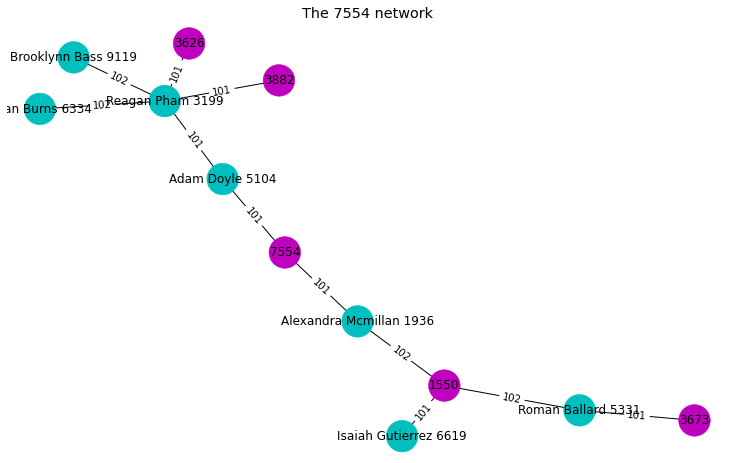

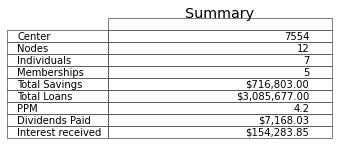

In [27]:
#specify subgraph
graph = multi[0]
colors = generate_color_map(graph,ind)

# Set up graph visualization and get attributes
center, title, node_count, fig1 = make_graph(graph, colors)

# separate member nodes and individual nodes
i,m = separate_members_individuals(graph)


# calculate summary stats of membership attributes
total_loan = sum(m['OPN_LN_BAL'])
total_saving = sum(m['OPN_SV_BAL'])
loan_count = sum(m['OPN_LN_ALL_CNT'])
saving_count = sum(m['OPN_SV_ALL_CNT'])
total_dividend = sum(m['DIV_YTD_AMT'])
total_interest = sum(m['INT_YTD_AMT'])

products_per_member = (loan_count + saving_count) / len(m)

plt.title(f'The {title} network')

# make summary table formatted for display
account_dict = {'Center':title,
                'Nodes':node_count, 
                'Individuals':len(i), 
                'Memberships':len(m),
                'Total Savings':f'${total_saving:,.2f}', 
                'Total Loans':f'${total_loan:,.2f}', 
                'PPM':f'{products_per_member:.2n}', 
                'Dividends Paid':f'${total_dividend:,.2f}', 
                'Interest received':f'${total_interest:,.2f}'}

act_df = pd.DataFrame.from_dict(account_dict, orient='index').rename(columns={0:''})

export_list = [f'=HYPERLINK("{title}.pdf")', node_count, len(i), len(m), total_saving, total_loan, products_per_member, total_dividend,
              total_interest]

# make the account summary table
fig2 = make_table(act_df)

# save graph and table as pdf
make_pdf(fig1, fig2, title)



### Test visualizing all subgraphs - running this cell will generate an output file in the current directory

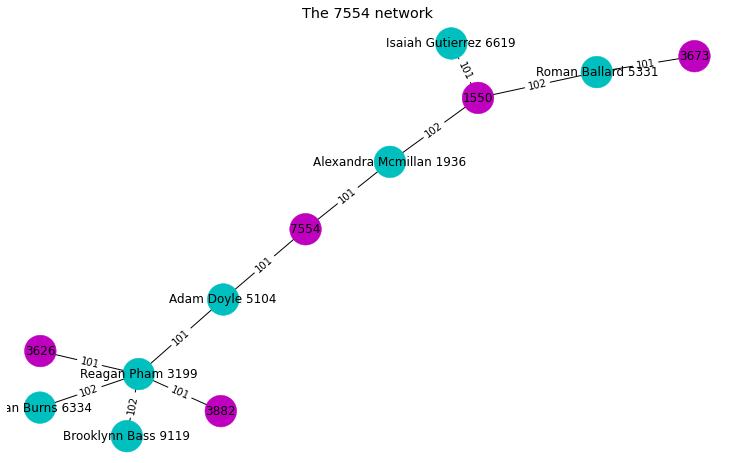

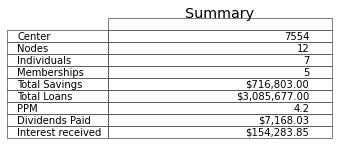

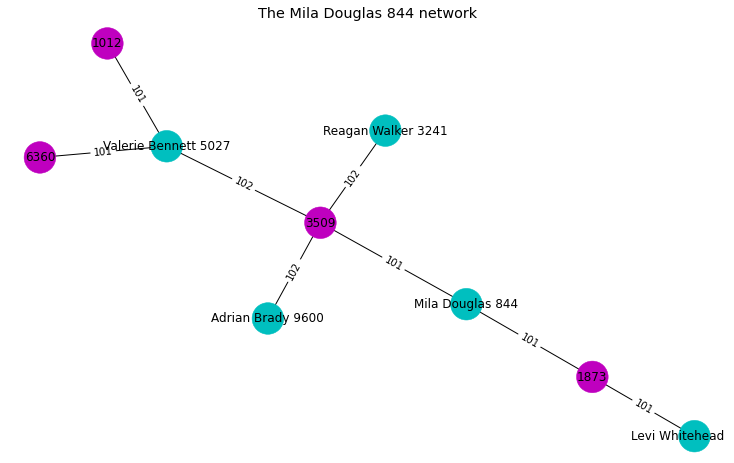

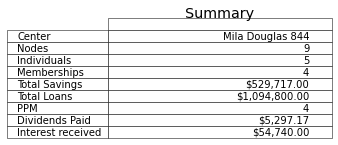

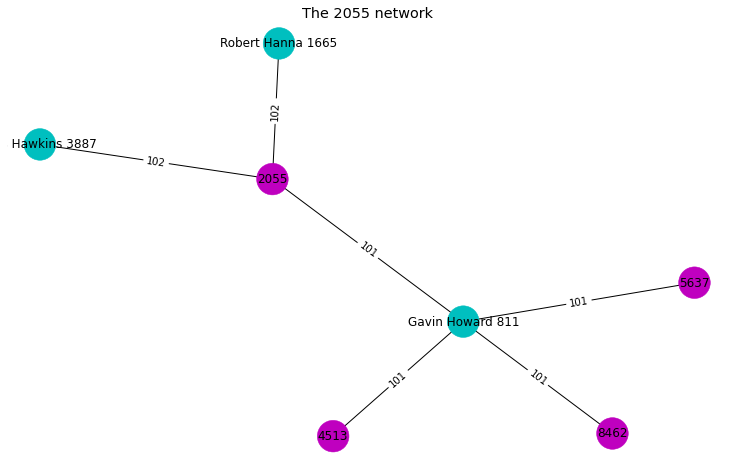

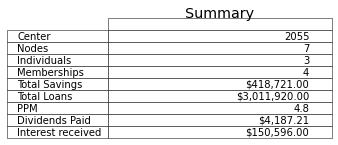

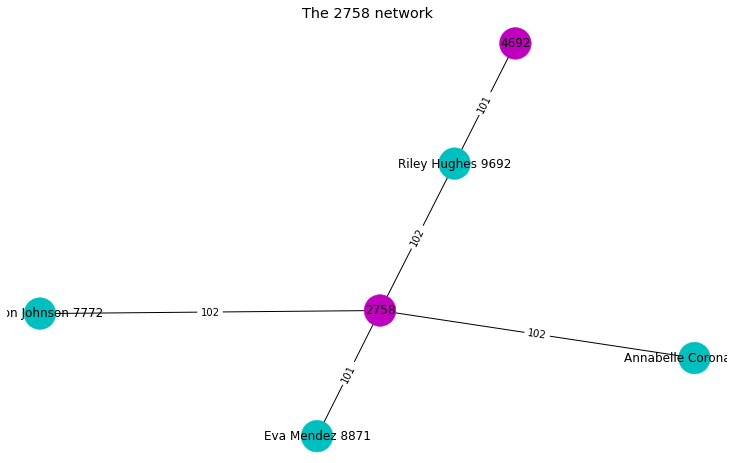

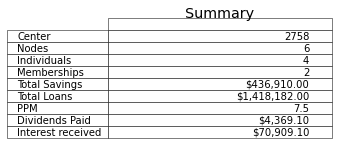

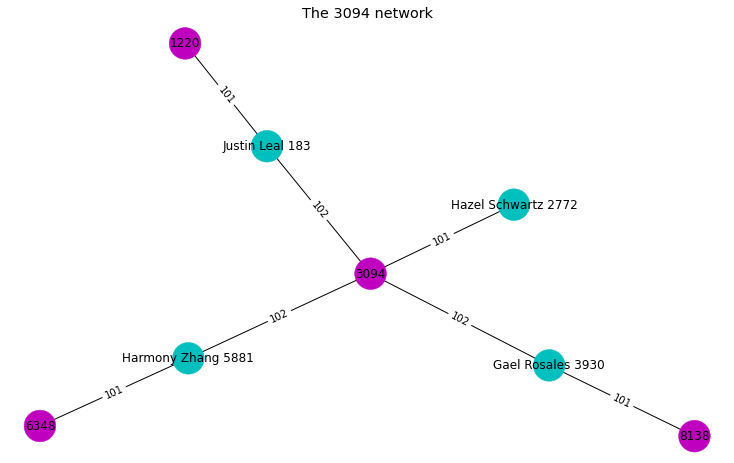

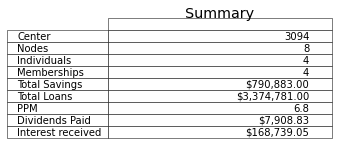

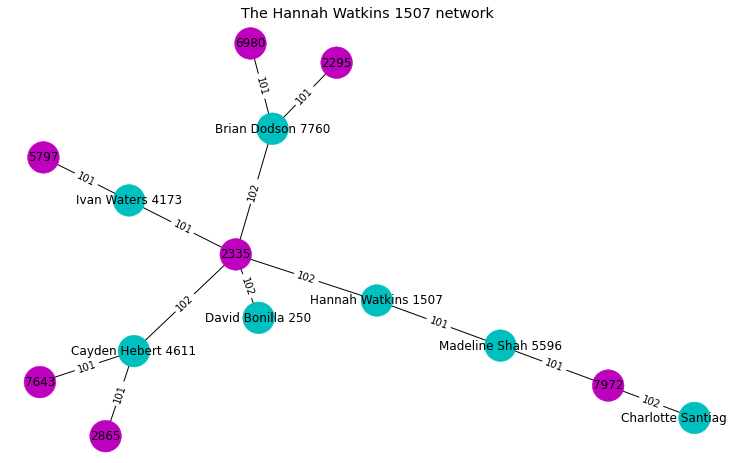

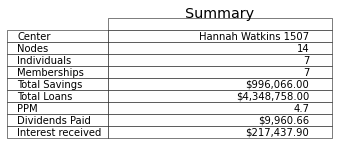

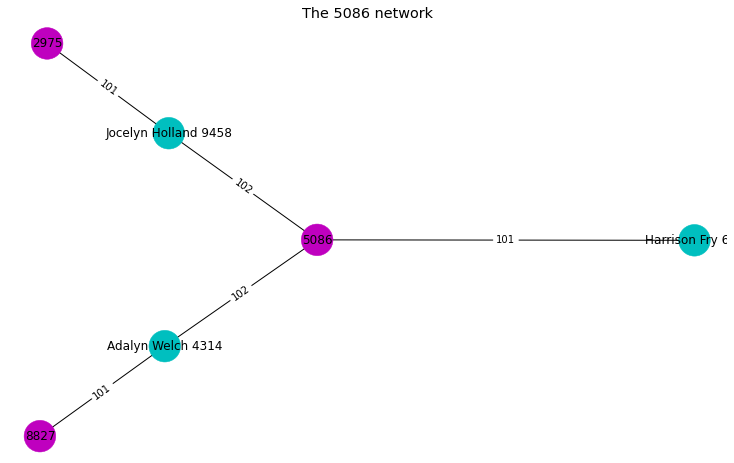

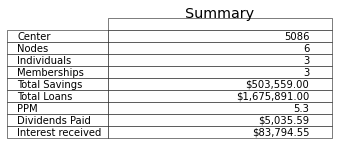

In [28]:
subnetwork_df = []
columns = ['Center', 'Nodes', 'Individuals', 'Memberships', 'Total Savings', 'Total Loans', 
           'PPM', 'Dividends Paid', 'Interest Received']
timestamp = datetime.now().date().strftime("%b %d %Y ")

igroup=[]
mgroup = []

for i in range(7):
        #specify subgraph
    graph = multi[i]
    colors = generate_color_map(graph,ind)

    # Set up graph visualization and get attributes
    center, title, node_count, fig1 = make_graph(graph, colors)

    # separate member nodes and individual nodes
    i,m = separate_members_individuals(graph)
    i2, m2 = format_member_individuals_for_concat(m, i, center)

    # calculate summary stats of membership attributes
    total_loan = sum(m['OPN_LN_BAL'])
    total_saving = sum(m['OPN_SV_BAL'])
    loan_count = sum(m['OPN_LN_ALL_CNT'])
    saving_count = sum(m['OPN_SV_ALL_CNT'])
    total_dividend = sum(m['DIV_YTD_AMT'])
    total_interest = sum(m['INT_YTD_AMT'])

    products_per_member = (loan_count + saving_count) / len(m)

    plt.title(f'The {title} network')

    # make summary table formatted for display
    account_dict = {'Center':title,
                    'Nodes':node_count, 
                    'Individuals':len(i), 
                    'Memberships':len(m),
                    'Total Savings':f'${total_saving:,.2f}', 
                    'Total Loans':f'${total_loan:,.2f}', 
                    'PPM':f'{products_per_member:.2n}', 
                    'Dividends Paid':f'${total_dividend:,.2f}', 
                    'Interest received':f'${total_interest:,.2f}'}

    act_df = pd.DataFrame.from_dict(account_dict, orient='index').rename(columns={0:''})

    export_list = [f'=HYPERLINK("{title}.pdf")', node_count, len(i), len(m), total_saving, total_loan, products_per_member, total_dividend,
                  total_interest]

    # make the account summary table
    fig2 = make_table(act_df)

    # save graph and table as pdf
    make_pdf(fig1, fig2, title)

    subnetwork_df.append(export_list)
    #igroup.append(i2)
    #mgroup.append(m2)
    igroup +=i2
    mgroup += m2
    #mgroup.append(m2)
    
individual_group = pd.DataFrame(igroup, columns = ['INDIVIDUAL_ID', 'GROUP'])
member_group = pd.DataFrame(mgroup, columns = ['MEMBER_NBR', 'GROUP'])
# Export to an excel spreadsheet with links to pdfs
d = pd.DataFrame(subnetwork_df, columns = columns)
d.to_excel(f'output\\Member subnetworks - {timestamp}.xlsx')
individual_group.to_csv(f'output\\individual_group_table-{timestamp}.csv')
member_group.to_csv(f'output\\member_group_table-{timestamp}.csv')